In [1]:
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.svm import SVC 
import pickle
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_score

# Auxiliary functions

These functions will be used during our training and analysis

In [2]:
def plot_cm(cm, class_names, figsize, fontsize):
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    fig = plt.figure(figsize=figsize)
    heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cmap='rocket')
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.title('SVM (Linear)')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Loading the sampled data from our videos

In [3]:
train_data = pickle.load(open('../output/scene_virat_12_train_120k.pkl','rb'))
random.shuffle(train_data)
X_train = [s[2] for s in train_data]
y_train = [s[1] for s in train_data]
print('Train samples: ', len(X_train))

Train samples:  119999


In [4]:
test_data = pickle.load(open('../output/scene_virat_12_test_10k.pkl','rb'))
random.shuffle(test_data)
X_test = [s[2] for s in test_data]
y_test = [s[1] for s in test_data]
print('Test samples:  ', len(X_test))

Test samples:   9996


### Training
Train the Multi-class SVM with a linear kernel and save it into disk.

In [5]:
# training a linear SVM classifier 
svm_model_linear = SVC(kernel = 'linear', C = 1, probability = True).fit(X_train, y_train)
clf_save_path = '/home/zal/Devel/Vehice_Action_Classifier/output/scene_clf_svm.pkl'
pickle.dump(svm_model_linear, open(clf_save_path, 'wb'))

### Testing
Then we test the trained model for accuracy and obtain the confusion matrix to get an insight of the performance of the model.

Accuracy: 0.9980992396958783


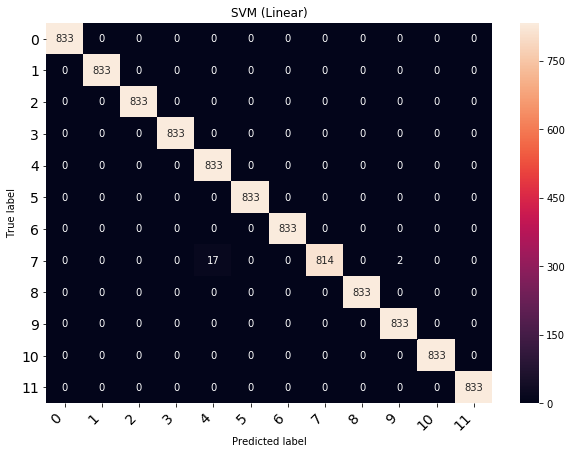

In [6]:
svm_predictions = svm_model_linear.predict(X_test) 

# model accuracy for X_test 
accuracy = svm_model_linear.score(X_test, y_test) 

# creating a confusion matrix 
cm = confusion_matrix(y_test, svm_predictions) 

print('Accuracy:', accuracy)
plot_cm(cm, class_names=[str(i) for i in range(12)], figsize = (10,7), fontsize = 14)

# Cross-validation

We cross validated the model to verify its robustness

In [ ]:
scores = cross_val_score(svm_model_linear, X_train, y_train, cv=5)
print(scores)

# Validate model

Validate the model by classifying videos based on first frames

In [8]:
import csv
import os.path as osp
import numpy as np
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms

data_path = '/home/zal/Data/VIRAT/Frames/first_frames'
anno_path = '/home/zal/Data/VIRAT/Frames/first_frames/annotations.csv'

In [9]:
anno_data = []
with open(anno_path, newline='') as csvfile:
    reader = csv.reader(csvfile)
    next(reader)
    anno_data = list(reader)

data_x, data_y = zip(*anno_data)
data_y = [int(y) for y in data_y]

In [10]:
data_y[np.argmax(data_y)]

18

In [5]:
def load_resnet(device):
    resnet = models.resnet18(pretrained=True).to(device)
    # Remove the clf layer
    modules = list(resnet.children())[:-1]
    resnet = nn.Sequential(*modules)
    # Inference, no need to calc gradient
    for param in resnet.parameters():
        param.requires_grad = False

    return resnet

def get_resnet_feats(img_path, resnet):
    img = Image.open(img_path).resize((224, 224), Image.ANTIALIAS)
    img_tensor = transforms.ToTensor()(img).view(1, 3, 224, 224).to(device)
    output = resnet(img_tensor).cpu().view(-1)
    return output.data.numpy()

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
resnet = load_resnet(device)

In [9]:
svm_model = pickle.load(open('/home/zal/Devel/Vehice_Action_Classifier/output/scene_19_clf_svm_linear.pkl', 'rb'))

In [10]:
cm = np.zeros((19,19))

for dir_name, y in zip(data_x,data_y):
    test_dir = osp.join(data_path, dir_name)
    resnet_feats = []
    for frame_path in glob(osp.join(test_dir, '*.jpg')):
        resnet_feats.append(get_resnet_feats(frame_path, resnet))
    frame_prediction = svm_model.predict(resnet_feats)
    vid_prediction = np.argmax(np.bincount(frame_prediction))
    cm[y, vid_prediction] += 1

In [12]:
accuracy = np.sum(np.diag(cm)) / np.sum(cm)
print(accuracy)

0.9942418426103646


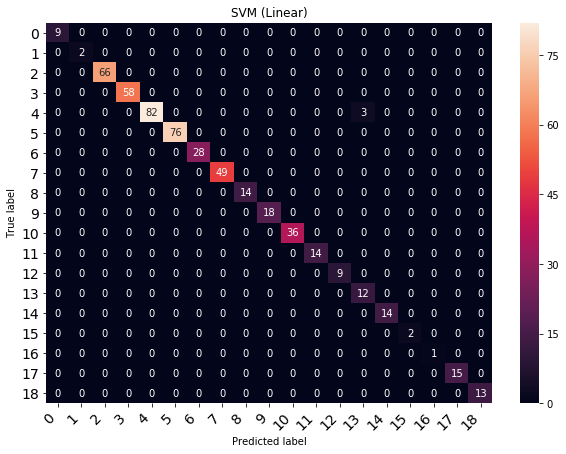

In [15]:
plot_cm(cm.astype(np.int), class_names=[str(i) for i in range(19)], figsize = (10,7), fontsize = 14)